In [1]:
import numpy as np
import pandas as pd
import joblib

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score

#### **Creating a Neural Network with TfidfVectorizer and Pytorch**

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading the Tokenized tweets**

In [3]:
tweets_train_tokenized = pd.read_csv('csvs/tweets_train_tokens.csv', index_col=False)
tweets_train_tokenized_message = pd.Series(tweets_train_tokenized.message)
# Converting Panda series into Unicode datatype as required by vectorizers
tweets = tweets_train_tokenized_message.astype('U').values
tweets

array(['arirang simply kpop kim hyung jun cross ha yeong playback',
       'read politico article donald trump running mate tom brady list likely choice',
       'type bazura project google image image photo dad glenn moustache whatthe',
       ..., 'bring dunkin iced coffee tomorrow hero',
       'currently holiday portugal come home tomorrow poland tuesday holocaust memorial trip',
       'ladykiller saturday aternoon'], dtype=object)

**B. Loading our target labels**

In [4]:
tweets_train_y = pd.read_csv('csvs/tweets_train_y.csv', index_col=False)
tweets_train_y = pd.Series(tweets_train_y['0'])
tweets_train_y = tweets_train_y.values
tweets_train_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [5]:
np.unique(tweets_train_y)

array([0, 1, 2], dtype=int64)

**C. Train-test Split**

In [6]:
X_full_train, X_test, y_full_train, y_test = train_test_split(tweets, tweets_train_y, test_size=0.2, random_state=21, stratify=tweets_train_y)
print('# Train data samples:', X_full_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_full_train.shape[0] == y_full_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 39740
# Test data samples: 9935


**D. Converting input texts to vectors using TfidfVectorizer**

In [7]:
# you can also specify ngram_range
# you can also choose the max_features parameter, which just includes those features with the top frequencies specified by the max_features i.e.
# max_features = 7500, includes only those top 7500 features with the highest frequencies
# min_df includes only words which appear at least twice in every document
# ngram_range=(1,2)
tfidf= joblib.load('vectors/tfidf.sav')
tfidf

TfidfVectorizer(max_features=5000, min_df=2, ngram_range=(1, 2))

In [8]:
X_full_train_vec = tfidf.transform(X_full_train).toarray()
X_test_vec = tfidf.transform(X_test).toarray()
X_test_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**E. Splitting train set for validation**

In [9]:
X_train_vec, X_val_vec, y_train_vec, y_val_vec = train_test_split(X_full_train_vec, y_full_train, test_size=0.2, random_state=21)

assert X_val_vec.shape[0] == y_val_vec.shape[0]
assert X_train_vec.shape[0] == y_train_vec.shape[0]

print('Shape of validation set:',X_val_vec.shape)

Shape of validation set: (7948, 5000)


**F. Converting features and targets into Tensors**

In [10]:
X_train_vec = torch.from_numpy(X_train_vec).type(torch.float)
y_train_vec = torch.from_numpy(y_train_vec).type(torch.LongTensor)

X_val_vec = torch.from_numpy(X_val_vec).type(torch.float)
y_val_vec = torch.from_numpy(y_val_vec).type(torch.LongTensor)

In [11]:
print(f'X_train_vec shape: {X_train_vec.shape}, y_train_vec shape: {y_train_vec.shape}')

X_train_vec shape: torch.Size([31792, 5000]), y_train_vec shape: torch.Size([31792])


**G. Creating our Neural Network Architecture** 

In [12]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
    
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y

In [13]:
# Create an instance of the model and send it to target device
model_0 = NeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_0

NeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

**H. Neural Network Hyperparameters**

In [14]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=learning_rate)
batch_size = 128

In [15]:
# Test structure of model
# predictions_before are the logits, or the raw, untrained output of the model
predictions_before = model_0.forward(torch.Tensor(X_val_vec).float())
predictions_before

tensor([[-0.0527, -0.0325,  0.0332],
        [-0.0535, -0.0407,  0.0299],
        [-0.0482, -0.0399,  0.0363],
        ...,
        [-0.0509, -0.0357,  0.0310],
        [-0.0544, -0.0341,  0.0336],
        [-0.0574, -0.0363,  0.0344]], grad_fn=<AddmmBackward0>)

In [16]:
y_pred_probs = torch.softmax(predictions_before, dim=1)
y_pred_probs

tensor([[0.3215, 0.3281, 0.3504],
        [0.3226, 0.3267, 0.3507],
        [0.3230, 0.3256, 0.3514],
        ...,
        [0.3225, 0.3274, 0.3501],
        [0.3213, 0.3279, 0.3508],
        [0.3208, 0.3276, 0.3516]], grad_fn=<SoftmaxBackward0>)

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value `using torch.argmax()`.

In [17]:
print(torch.argmax(y_pred_probs, dim=1))

tensor([2, 2, 2,  ..., 2, 2, 2])


You can see the output of torch.argmax() returns 0, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 0.

Of course, right now this is just random guessing so it's got a 33% chance of being right (since there's three classes). But we can improve those chances by training the model.

In [18]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

**I. Training the Network**

In [19]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=X_train_vec, y=y_train_vec)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_0,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_0.state_dict() }
torch.save(state, "./torch_models/model_0.pth")

Epoch: 0


100%|██████████| 249/249 [00:02<00:00, 96.32it/s, loss=1.05] 


Ave Loss: 1.0751942219025639
Epoch: 1


100%|██████████| 249/249 [00:01<00:00, 128.57it/s, loss=0.998]


Ave Loss: 1.02970099736409
Epoch: 2


100%|██████████| 249/249 [00:01<00:00, 136.38it/s, loss=0.952]


Ave Loss: 0.9854317666536354
Epoch: 3


100%|██████████| 249/249 [00:01<00:00, 148.10it/s, loss=0.911]


Ave Loss: 0.94681774516661
Epoch: 4


100%|██████████| 249/249 [00:01<00:00, 145.58it/s, loss=0.872]


Ave Loss: 0.9104285623175074
Epoch: 5


100%|██████████| 249/249 [00:01<00:00, 152.50it/s, loss=0.834]


Ave Loss: 0.8766134053349016
Epoch: 6


100%|██████████| 249/249 [00:01<00:00, 144.69it/s, loss=0.797]


Ave Loss: 0.8461665343568028
Epoch: 7


100%|██████████| 249/249 [00:01<00:00, 148.84it/s, loss=0.763]


Ave Loss: 0.8193175594011942
Epoch: 8


100%|██████████| 249/249 [00:01<00:00, 139.88it/s, loss=0.732]


Ave Loss: 0.7958324281087362
Epoch: 9


100%|██████████| 249/249 [00:02<00:00, 121.88it/s, loss=0.702]


Ave Loss: 0.7752940597304379
Epoch: 10


100%|██████████| 249/249 [00:01<00:00, 143.50it/s, loss=0.675]


Ave Loss: 0.7572709862965656
Epoch: 11


100%|██████████| 249/249 [00:01<00:00, 144.84it/s, loss=0.651]


Ave Loss: 0.7413802762108156
Epoch: 12


100%|██████████| 249/249 [00:01<00:00, 145.81it/s, loss=0.628]


Ave Loss: 0.727299288573514
Epoch: 13


100%|██████████| 249/249 [00:01<00:00, 147.54it/s, loss=0.607]


Ave Loss: 0.7147599104417854
Epoch: 14


100%|██████████| 249/249 [00:01<00:00, 141.88it/s, loss=0.588]


Ave Loss: 0.7035411428734959
Epoch: 15


100%|██████████| 249/249 [00:01<00:00, 137.71it/s, loss=0.57] 


Ave Loss: 0.6934562679754204
Epoch: 16


100%|██████████| 249/249 [00:01<00:00, 125.70it/s, loss=0.554]


Ave Loss: 0.6843489394130478
Epoch: 17


100%|██████████| 249/249 [00:01<00:00, 129.71it/s, loss=0.539]


Ave Loss: 0.6760919639863163
Epoch: 18


100%|██████████| 249/249 [00:01<00:00, 132.69it/s, loss=0.525]


Ave Loss: 0.6685763915858595
Epoch: 19


100%|██████████| 249/249 [00:01<00:00, 125.59it/s, loss=0.512]


Ave Loss: 0.6617095491972315
Epoch: 20


100%|██████████| 249/249 [00:01<00:00, 133.37it/s, loss=0.5]  


Ave Loss: 0.6554125608449959
Epoch: 21


100%|██████████| 249/249 [00:01<00:00, 127.92it/s, loss=0.489]


Ave Loss: 0.6496199523828116
Epoch: 22


100%|██████████| 249/249 [00:01<00:00, 128.22it/s, loss=0.478]


Ave Loss: 0.6442744988035486
Epoch: 23


100%|██████████| 249/249 [00:01<00:00, 127.14it/s, loss=0.468]


Ave Loss: 0.6393261709845209
Epoch: 24


100%|██████████| 249/249 [00:01<00:00, 137.17it/s, loss=0.459]


Ave Loss: 0.6347330748795506
Epoch: 25


100%|██████████| 249/249 [00:01<00:00, 148.62it/s, loss=0.45] 


Ave Loss: 0.6304571213253052
Epoch: 26


100%|██████████| 249/249 [00:01<00:00, 127.60it/s, loss=0.441]


Ave Loss: 0.6264664689939184
Epoch: 27


100%|██████████| 249/249 [00:02<00:00, 123.13it/s, loss=0.434]


Ave Loss: 0.6227343278716367
Epoch: 28


100%|██████████| 249/249 [00:02<00:00, 119.44it/s, loss=0.426]


Ave Loss: 0.6192346232004434
Epoch: 29


100%|██████████| 249/249 [00:01<00:00, 128.75it/s, loss=0.419]


Ave Loss: 0.6159476746756389
Epoch: 30


100%|██████████| 249/249 [00:01<00:00, 129.70it/s, loss=0.413]


Ave Loss: 0.612854557463443
Epoch: 31


100%|██████████| 249/249 [00:01<00:00, 127.14it/s, loss=0.407]


Ave Loss: 0.6099363353597113
Epoch: 32


100%|██████████| 249/249 [00:01<00:00, 131.18it/s, loss=0.401]


Ave Loss: 0.6071789354444986
Epoch: 33


100%|██████████| 249/249 [00:01<00:00, 125.37it/s, loss=0.395]


Ave Loss: 0.6045691505014656
Epoch: 34


100%|██████████| 249/249 [00:01<00:00, 124.72it/s, loss=0.39] 


Ave Loss: 0.6020947482930609
Epoch: 35


100%|██████████| 249/249 [00:01<00:00, 133.71it/s, loss=0.385]


Ave Loss: 0.599744444630711
Epoch: 36


100%|██████████| 249/249 [00:01<00:00, 126.47it/s, loss=0.38] 


Ave Loss: 0.59750834167243
Epoch: 37


100%|██████████| 249/249 [00:01<00:00, 131.84it/s, loss=0.376]


Ave Loss: 0.5953787148716938
Epoch: 38


100%|██████████| 249/249 [00:01<00:00, 132.65it/s, loss=0.372]


Ave Loss: 0.5933467665589957
Epoch: 39


100%|██████████| 249/249 [00:01<00:00, 136.80it/s, loss=0.368]


Ave Loss: 0.5914059697863567
Epoch: 40


100%|██████████| 249/249 [00:01<00:00, 132.82it/s, loss=0.364]


Ave Loss: 0.5895476129399725
Epoch: 41


100%|██████████| 249/249 [00:01<00:00, 133.42it/s, loss=0.36] 


Ave Loss: 0.5877672632535299
Epoch: 42


100%|██████████| 249/249 [00:01<00:00, 134.35it/s, loss=0.357]


Ave Loss: 0.5860584333957918
Epoch: 43


100%|██████████| 249/249 [00:01<00:00, 131.35it/s, loss=0.354]


Ave Loss: 0.584416283302039
Epoch: 44


100%|██████████| 249/249 [00:01<00:00, 139.47it/s, loss=0.351]


Ave Loss: 0.5828364761957682
Epoch: 45


100%|██████████| 249/249 [00:01<00:00, 135.84it/s, loss=0.348]


Ave Loss: 0.5813155881611698
Epoch: 46


100%|██████████| 249/249 [00:01<00:00, 139.02it/s, loss=0.345]


Ave Loss: 0.5798490975037157
Epoch: 47


100%|██████████| 249/249 [00:01<00:00, 131.71it/s, loss=0.342]


Ave Loss: 0.5784344381117916
Epoch: 48


100%|██████████| 249/249 [00:01<00:00, 136.25it/s, loss=0.34] 


Ave Loss: 0.5770665982880266
Epoch: 49


100%|██████████| 249/249 [00:01<00:00, 133.58it/s, loss=0.337]


Ave Loss: 0.5757445323180004
Epoch: 50


100%|██████████| 249/249 [00:01<00:00, 129.55it/s, loss=0.335]


Ave Loss: 0.5744645952220901
Epoch: 51


100%|██████████| 249/249 [00:01<00:00, 135.42it/s, loss=0.333]


Ave Loss: 0.5732247446435522
Epoch: 52


100%|██████████| 249/249 [00:01<00:00, 135.70it/s, loss=0.331]


Ave Loss: 0.5720224409218294
Epoch: 53


100%|██████████| 249/249 [00:01<00:00, 137.09it/s, loss=0.328]


Ave Loss: 0.5708546541541456
Epoch: 54


100%|██████████| 249/249 [00:01<00:00, 135.42it/s, loss=0.327]


Ave Loss: 0.5697198944637575
Epoch: 55


100%|██████████| 249/249 [00:01<00:00, 139.32it/s, loss=0.325]


Ave Loss: 0.568617034269624
Epoch: 56


100%|██████████| 249/249 [00:01<00:00, 132.07it/s, loss=0.323]


Ave Loss: 0.5675433936368031
Epoch: 57


100%|██████████| 249/249 [00:01<00:00, 136.86it/s, loss=0.321]


Ave Loss: 0.5664992636466122
Epoch: 58


100%|██████████| 249/249 [00:01<00:00, 134.15it/s, loss=0.319]


Ave Loss: 0.5654831503529146
Epoch: 59


100%|██████████| 249/249 [00:01<00:00, 135.16it/s, loss=0.318]


Ave Loss: 0.5644899987312685
Epoch: 60


100%|██████████| 249/249 [00:01<00:00, 139.00it/s, loss=0.316]


Ave Loss: 0.5635220428786604
Epoch: 61


100%|██████████| 249/249 [00:01<00:00, 131.66it/s, loss=0.315]


Ave Loss: 0.5625776428295427
Epoch: 62


100%|██████████| 249/249 [00:01<00:00, 136.29it/s, loss=0.313]


Ave Loss: 0.5616532737710869
Epoch: 63


100%|██████████| 249/249 [00:01<00:00, 134.60it/s, loss=0.312]


Ave Loss: 0.5607494564659624
Epoch: 64


100%|██████████| 249/249 [00:01<00:00, 138.73it/s, loss=0.311]


Ave Loss: 0.5598650190485529
Epoch: 65


100%|██████████| 249/249 [00:01<00:00, 133.96it/s, loss=0.31] 


Ave Loss: 0.5590000107106434
Epoch: 66


100%|██████████| 249/249 [00:01<00:00, 132.44it/s, loss=0.308]


Ave Loss: 0.5581521730585749
Epoch: 67


100%|██████████| 249/249 [00:01<00:00, 137.13it/s, loss=0.307]


Ave Loss: 0.5573218145284308
Epoch: 68


100%|██████████| 249/249 [00:01<00:00, 124.67it/s, loss=0.306]


Ave Loss: 0.5565075566730346
Epoch: 69


100%|██████████| 249/249 [00:01<00:00, 138.33it/s, loss=0.305]


Ave Loss: 0.5557093069735302
Epoch: 70


100%|██████████| 249/249 [00:01<00:00, 131.12it/s, loss=0.304]


Ave Loss: 0.5549248683165355
Epoch: 71


100%|██████████| 249/249 [00:01<00:00, 138.99it/s, loss=0.303]


Ave Loss: 0.5541541005473539
Epoch: 72


100%|██████████| 249/249 [00:01<00:00, 133.01it/s, loss=0.302]


Ave Loss: 0.5533971142577359
Epoch: 73


100%|██████████| 249/249 [00:01<00:00, 135.33it/s, loss=0.301]


Ave Loss: 0.552652206885288
Epoch: 74


100%|██████████| 249/249 [00:01<00:00, 135.46it/s, loss=0.3]  


Ave Loss: 0.5519181651523314
Epoch: 75


100%|██████████| 249/249 [00:01<00:00, 128.17it/s, loss=0.299]


Ave Loss: 0.5511975670195967
Epoch: 76


100%|██████████| 249/249 [00:02<00:00, 120.60it/s, loss=0.298]


Ave Loss: 0.5504881946676706
Epoch: 77


100%|██████████| 249/249 [00:02<00:00, 124.30it/s, loss=0.298]


Ave Loss: 0.549788233745529
Epoch: 78


100%|██████████| 249/249 [00:01<00:00, 132.06it/s, loss=0.297]


Ave Loss: 0.549099478137541
Epoch: 79


100%|██████████| 249/249 [00:02<00:00, 123.56it/s, loss=0.296]


Ave Loss: 0.548419266101347
Epoch: 80


100%|██████████| 249/249 [00:01<00:00, 129.06it/s, loss=0.295]


Ave Loss: 0.5477474413243643
Epoch: 81


100%|██████████| 249/249 [00:01<00:00, 128.04it/s, loss=0.295]


Ave Loss: 0.5470848669967499
Epoch: 82


100%|██████████| 249/249 [00:01<00:00, 127.56it/s, loss=0.294]


Ave Loss: 0.5464298865163183
Epoch: 83


100%|██████████| 249/249 [00:01<00:00, 126.92it/s, loss=0.293]


Ave Loss: 0.5457828791744738
Epoch: 84


100%|██████████| 249/249 [00:01<00:00, 127.33it/s, loss=0.293]


Ave Loss: 0.5451418956120809
Epoch: 85


100%|██████████| 249/249 [00:01<00:00, 125.13it/s, loss=0.292]


Ave Loss: 0.5445088216339249
Epoch: 86


100%|██████████| 249/249 [00:01<00:00, 130.11it/s, loss=0.291]


Ave Loss: 0.5438828463535232
Epoch: 87


100%|██████████| 249/249 [00:02<00:00, 121.28it/s, loss=0.291]


Ave Loss: 0.5432627191505279
Epoch: 88


100%|██████████| 249/249 [00:01<00:00, 131.85it/s, loss=0.29] 


Ave Loss: 0.5426454697268076
Epoch: 89


100%|██████████| 249/249 [00:02<00:00, 124.27it/s, loss=0.289]


Ave Loss: 0.5420379048609829
Epoch: 90


100%|██████████| 249/249 [00:02<00:00, 122.38it/s, loss=0.289]


Ave Loss: 0.541431489838175
Epoch: 91


100%|██████████| 249/249 [00:01<00:00, 126.51it/s, loss=0.288]


Ave Loss: 0.5408334493876461
Epoch: 92


100%|██████████| 249/249 [00:01<00:00, 127.47it/s, loss=0.288]


Ave Loss: 0.5402401763511949
Epoch: 93


100%|██████████| 249/249 [00:01<00:00, 129.02it/s, loss=0.287]


Ave Loss: 0.5396496450087153
Epoch: 94


100%|██████████| 249/249 [00:01<00:00, 125.13it/s, loss=0.287]


Ave Loss: 0.5390641161476273
Epoch: 95


100%|██████████| 249/249 [00:02<00:00, 123.83it/s, loss=0.286]


Ave Loss: 0.5384852153709135
Epoch: 96


100%|██████████| 249/249 [00:01<00:00, 131.92it/s, loss=0.285]


Ave Loss: 0.5379094389308409
Epoch: 97


100%|██████████| 249/249 [00:01<00:00, 126.92it/s, loss=0.285]


Ave Loss: 0.5373352434501112
Epoch: 98


100%|██████████| 249/249 [00:01<00:00, 127.17it/s, loss=0.284]


Ave Loss: 0.5367667871306699
Epoch: 99


100%|██████████| 249/249 [00:02<00:00, 122.14it/s, loss=0.284]


Ave Loss: 0.5362022133716139
Training duration: 189.34450888633728 seconds


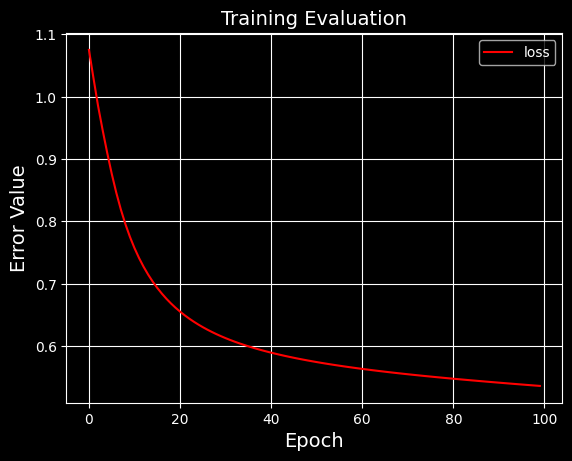

In [20]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**J. Validating Network Performance**

In [21]:
model = NeuralNetwork(5000,3)
state = torch.load("./torch_models/model_0.pth")
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [22]:
predictions_after = model.forward(torch.Tensor(X_val_vec))
#predictions_after = torch.argmax(predictions_after)
#predictions_after

In [23]:
predictions_after = torch.softmax(predictions_after, dim=1)

In [24]:
predictions = torch.argmax(predictions_after, dim=1)
predictions

tensor([1, 2, 1,  ..., 1, 2, 1])

In [25]:
#predictions_after = predictions_after.squeeze()
#predictions_after.shape

In [26]:
y_val_vec

tensor([1, 1, 2,  ..., 0, 2, 1])

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val_vec, predictions)
accuracy

0.6182687468545546

In [28]:
from sklearn.metrics import recall_score

recall_score = recall_score(y_val_vec, predictions, average='macro')
recall_score

0.5795912608621049

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_val_vec, predictions))

              precision    recall  f1-score   support

           0       0.50      0.44      0.47      1208
           1       0.61      0.66      0.63      3529
           2       0.67      0.64      0.66      3211

    accuracy                           0.62      7948
   macro avg       0.59      0.58      0.59      7948
weighted avg       0.62      0.62      0.62      7948



Based on our experimentation on validation data, as can be seen in `Experiments.docx`, we have arrived at the following hyperparameters which produced the best results:

Number of Hidden Layers: 1 \
Number of Neurons in Hidden Layer: 50 \
Batch size: 128 \
Learning Rate: 0.0001 \
Function Loss: CrossEntropyLoss() \
Optimizer: Adam \
Number of Training Epochs: 100 

We will retrain our model using a much larger dataset using these hyperparameters.

**K. Retraining the Network**

In [30]:
X_full_train_vec = torch.from_numpy(X_full_train_vec).type(torch.float)
y_full_train = torch.from_numpy(y_full_train).type(torch.LongTensor)

X_test_vec = torch.from_numpy(X_test_vec).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [31]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class FullNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
    
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y


In [32]:
# Create an instance of the model and send it to target device
model_1 = FullNeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_1

FullNeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

In [33]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate)
batch_size = 128

In [34]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [35]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer_1.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer_1.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=X_full_train_vec, y=y_full_train)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses_1 = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_1,
        optimizer_1,
        loss_fn,
        batch_size
    )
    
    losses_1.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_1.state_dict() }
torch.save(state, "./torch_models/model_1.pth")

Epoch: 0


100%|██████████| 311/311 [00:02<00:00, 125.08it/s, loss=1.04]


Ave Loss: 1.0538668115039347
Epoch: 1


100%|██████████| 311/311 [00:02<00:00, 145.49it/s, loss=0.981]


Ave Loss: 1.0046111379789002
Epoch: 2


100%|██████████| 311/311 [00:02<00:00, 148.49it/s, loss=0.925]


Ave Loss: 0.9544255706658318
Epoch: 3


100%|██████████| 311/311 [00:02<00:00, 151.76it/s, loss=0.874]


Ave Loss: 0.909470790643784
Epoch: 4


100%|██████████| 311/311 [00:02<00:00, 139.22it/s, loss=0.828]


Ave Loss: 0.8695334970376116
Epoch: 5


100%|██████████| 311/311 [00:02<00:00, 126.27it/s, loss=0.788]


Ave Loss: 0.8353028446915065
Epoch: 6


100%|██████████| 311/311 [00:02<00:00, 123.82it/s, loss=0.753]


Ave Loss: 0.8064692898195273
Epoch: 7


100%|██████████| 311/311 [00:02<00:00, 133.15it/s, loss=0.722]


Ave Loss: 0.7821920004304965
Epoch: 8


100%|██████████| 311/311 [00:02<00:00, 140.83it/s, loss=0.695]


Ave Loss: 0.761643375997758
Epoch: 9


100%|██████████| 311/311 [00:02<00:00, 134.53it/s, loss=0.67] 


Ave Loss: 0.7441315116223032
Epoch: 10


100%|██████████| 311/311 [00:02<00:00, 124.49it/s, loss=0.648]


Ave Loss: 0.7291091946926914
Epoch: 11


100%|██████████| 311/311 [00:02<00:00, 143.63it/s, loss=0.628]


Ave Loss: 0.7161324378761831
Epoch: 12


100%|██████████| 311/311 [00:02<00:00, 120.63it/s, loss=0.61] 


Ave Loss: 0.7048463470682838
Epoch: 13


100%|██████████| 311/311 [00:02<00:00, 128.18it/s, loss=0.594]


Ave Loss: 0.6949692004363254
Epoch: 14


100%|██████████| 311/311 [00:02<00:00, 143.00it/s, loss=0.579]


Ave Loss: 0.6862684325389924
Epoch: 15


100%|██████████| 311/311 [00:02<00:00, 140.04it/s, loss=0.565]


Ave Loss: 0.6785563261179295
Epoch: 16


100%|██████████| 311/311 [00:02<00:00, 140.66it/s, loss=0.553]


Ave Loss: 0.6716813286017759
Epoch: 17


100%|██████████| 311/311 [00:02<00:00, 149.45it/s, loss=0.541]


Ave Loss: 0.6655193427367992
Epoch: 18


100%|██████████| 311/311 [00:02<00:00, 139.29it/s, loss=0.531]


Ave Loss: 0.6599706901039725
Epoch: 19


100%|██████████| 311/311 [00:02<00:00, 143.62it/s, loss=0.521]


Ave Loss: 0.6549506507502492
Epoch: 20


100%|██████████| 311/311 [00:02<00:00, 132.75it/s, loss=0.512]


Ave Loss: 0.6503868071404301
Epoch: 21


100%|██████████| 311/311 [00:02<00:00, 130.13it/s, loss=0.504]


Ave Loss: 0.6462218532416598
Epoch: 22


100%|██████████| 311/311 [00:02<00:00, 123.81it/s, loss=0.497]


Ave Loss: 0.6424036874073494
Epoch: 23


100%|██████████| 311/311 [00:02<00:00, 125.99it/s, loss=0.49] 


Ave Loss: 0.638890143280244
Epoch: 24


100%|██████████| 311/311 [00:02<00:00, 130.05it/s, loss=0.483]


Ave Loss: 0.6356471972450183
Epoch: 25


100%|██████████| 311/311 [00:02<00:00, 136.30it/s, loss=0.477]


Ave Loss: 0.6326428326954796
Epoch: 26


100%|██████████| 311/311 [00:02<00:00, 128.10it/s, loss=0.472]


Ave Loss: 0.6298504371160096
Epoch: 27


100%|██████████| 311/311 [00:02<00:00, 132.21it/s, loss=0.467]


Ave Loss: 0.6272479249733437
Epoch: 28


100%|██████████| 311/311 [00:02<00:00, 134.27it/s, loss=0.462]


Ave Loss: 0.6248168625248973
Epoch: 29


100%|██████████| 311/311 [00:02<00:00, 131.42it/s, loss=0.458]


Ave Loss: 0.6225382352181953
Epoch: 30


100%|██████████| 311/311 [00:02<00:00, 129.86it/s, loss=0.453]


Ave Loss: 0.6203962912321858
Epoch: 31


100%|██████████| 311/311 [00:02<00:00, 132.11it/s, loss=0.449]


Ave Loss: 0.618378537165007
Epoch: 32


100%|██████████| 311/311 [00:02<00:00, 137.83it/s, loss=0.446]


Ave Loss: 0.6164733848004479
Epoch: 33


100%|██████████| 311/311 [00:02<00:00, 132.71it/s, loss=0.442]


Ave Loss: 0.6146703355756986
Epoch: 34


100%|██████████| 311/311 [00:02<00:00, 130.22it/s, loss=0.439]


Ave Loss: 0.6129611654871913
Epoch: 35


100%|██████████| 311/311 [00:02<00:00, 136.57it/s, loss=0.436]


Ave Loss: 0.611335958027763
Epoch: 36


100%|██████████| 311/311 [00:02<00:00, 133.97it/s, loss=0.433]


Ave Loss: 0.6097878761996793
Epoch: 37


100%|██████████| 311/311 [00:02<00:00, 132.86it/s, loss=0.43] 


Ave Loss: 0.6083101743287213
Epoch: 38


100%|██████████| 311/311 [00:02<00:00, 131.30it/s, loss=0.428]


Ave Loss: 0.6068971531759121
Epoch: 39


100%|██████████| 311/311 [00:02<00:00, 135.98it/s, loss=0.425]


Ave Loss: 0.6055429188768197
Epoch: 40


100%|██████████| 311/311 [00:02<00:00, 133.91it/s, loss=0.423]


Ave Loss: 0.6042444167413129
Epoch: 41


100%|██████████| 311/311 [00:02<00:00, 129.67it/s, loss=0.421]


Ave Loss: 0.6029953733326154
Epoch: 42


100%|██████████| 311/311 [00:02<00:00, 137.31it/s, loss=0.419]


Ave Loss: 0.6017927399977228
Epoch: 43


100%|██████████| 311/311 [00:02<00:00, 132.78it/s, loss=0.417]


Ave Loss: 0.6006320348889881
Epoch: 44


100%|██████████| 311/311 [00:02<00:00, 132.39it/s, loss=0.415]


Ave Loss: 0.5995113542033929
Epoch: 45


100%|██████████| 311/311 [00:02<00:00, 131.74it/s, loss=0.413]


Ave Loss: 0.5984285236171587
Epoch: 46


100%|██████████| 311/311 [00:02<00:00, 134.97it/s, loss=0.411]


Ave Loss: 0.5973813763768726
Epoch: 47


100%|██████████| 311/311 [00:02<00:00, 129.33it/s, loss=0.409]


Ave Loss: 0.5963663513445777
Epoch: 48


100%|██████████| 311/311 [00:02<00:00, 132.98it/s, loss=0.408]


Ave Loss: 0.595382589044295
Epoch: 49


100%|██████████| 311/311 [00:02<00:00, 132.33it/s, loss=0.406]


Ave Loss: 0.5944276945575641
Epoch: 50


100%|██████████| 311/311 [00:02<00:00, 132.16it/s, loss=0.404]


Ave Loss: 0.5935003466161501
Epoch: 51


100%|██████████| 311/311 [00:02<00:00, 132.75it/s, loss=0.403]


Ave Loss: 0.5925971403765908
Epoch: 52


100%|██████████| 311/311 [00:02<00:00, 136.07it/s, loss=0.402]


Ave Loss: 0.591715061012955
Epoch: 53


100%|██████████| 311/311 [00:02<00:00, 131.23it/s, loss=0.4]  


Ave Loss: 0.59085519463303
Epoch: 54


100%|██████████| 311/311 [00:02<00:00, 131.77it/s, loss=0.399]


Ave Loss: 0.5900155360484046
Epoch: 55


100%|██████████| 311/311 [00:02<00:00, 133.18it/s, loss=0.398]


Ave Loss: 0.5891956349661113
Epoch: 56


100%|██████████| 311/311 [00:02<00:00, 135.48it/s, loss=0.396]


Ave Loss: 0.5883922963088731
Epoch: 57


100%|██████████| 311/311 [00:02<00:00, 130.42it/s, loss=0.395]


Ave Loss: 0.5876067761822912
Epoch: 58


100%|██████████| 311/311 [00:02<00:00, 130.16it/s, loss=0.394]


Ave Loss: 0.5868363667914338
Epoch: 59


100%|██████████| 311/311 [00:02<00:00, 131.32it/s, loss=0.393]


Ave Loss: 0.5860797244444538
Epoch: 60


100%|██████████| 311/311 [00:02<00:00, 122.80it/s, loss=0.392]


Ave Loss: 0.5853362297130168
Epoch: 61


100%|██████████| 311/311 [00:02<00:00, 125.33it/s, loss=0.391]


Ave Loss: 0.5846053370517167
Epoch: 62


100%|██████████| 311/311 [00:02<00:00, 124.54it/s, loss=0.389]


Ave Loss: 0.5838860411352667
Epoch: 63


100%|██████████| 311/311 [00:02<00:00, 125.55it/s, loss=0.388]


Ave Loss: 0.5831793595548611
Epoch: 64


100%|██████████| 311/311 [00:02<00:00, 127.78it/s, loss=0.387]


Ave Loss: 0.5824859489198666
Epoch: 65


100%|██████████| 311/311 [00:02<00:00, 127.33it/s, loss=0.386]


Ave Loss: 0.5818000072643305
Epoch: 66


100%|██████████| 311/311 [00:02<00:00, 130.01it/s, loss=0.385]


Ave Loss: 0.5811237539509102
Epoch: 67


100%|██████████| 311/311 [00:02<00:00, 129.28it/s, loss=0.384]


Ave Loss: 0.5804554692610284
Epoch: 68


100%|██████████| 311/311 [00:02<00:00, 128.42it/s, loss=0.384]


Ave Loss: 0.5797945808176059
Epoch: 69


100%|██████████| 311/311 [00:02<00:00, 123.38it/s, loss=0.383]


Ave Loss: 0.5791416259248924
Epoch: 70


100%|██████████| 311/311 [00:02<00:00, 123.26it/s, loss=0.382]


Ave Loss: 0.5784956089361688
Epoch: 71


100%|██████████| 311/311 [00:02<00:00, 127.76it/s, loss=0.381]


Ave Loss: 0.5778567473796403
Epoch: 72


100%|██████████| 311/311 [00:02<00:00, 122.44it/s, loss=0.38] 


Ave Loss: 0.5772227075705574
Epoch: 73


100%|██████████| 311/311 [00:02<00:00, 125.85it/s, loss=0.379]


Ave Loss: 0.5765940958089001
Epoch: 74


100%|██████████| 311/311 [00:02<00:00, 125.32it/s, loss=0.379]


Ave Loss: 0.575972077164236
Epoch: 75


100%|██████████| 311/311 [00:02<00:00, 125.69it/s, loss=0.378]


Ave Loss: 0.5753525760012808
Epoch: 76


100%|██████████| 311/311 [00:02<00:00, 124.61it/s, loss=0.377]


Ave Loss: 0.5747372249315023
Epoch: 77


100%|██████████| 311/311 [00:02<00:00, 122.09it/s, loss=0.376]


Ave Loss: 0.5741257767202004
Epoch: 78


100%|██████████| 311/311 [00:02<00:00, 122.65it/s, loss=0.376]


Ave Loss: 0.5735202184444071
Epoch: 79


100%|██████████| 311/311 [00:02<00:00, 128.09it/s, loss=0.375]


Ave Loss: 0.5729187420326797
Epoch: 80


100%|██████████| 311/311 [00:02<00:00, 120.17it/s, loss=0.374]


Ave Loss: 0.5723187340800785
Epoch: 81


100%|██████████| 311/311 [00:02<00:00, 124.66it/s, loss=0.373]


Ave Loss: 0.5717226213197616
Epoch: 82


100%|██████████| 311/311 [00:02<00:00, 123.65it/s, loss=0.373]


Ave Loss: 0.5711277391749563
Epoch: 83


100%|██████████| 311/311 [00:02<00:00, 124.43it/s, loss=0.372]


Ave Loss: 0.5705358794264471
Epoch: 84


100%|██████████| 311/311 [00:02<00:00, 123.88it/s, loss=0.371]


Ave Loss: 0.5699447652151347
Epoch: 85


100%|██████████| 311/311 [00:02<00:00, 125.29it/s, loss=0.371]


Ave Loss: 0.5693535291113654
Epoch: 86


100%|██████████| 311/311 [00:02<00:00, 121.41it/s, loss=0.37] 


Ave Loss: 0.5687646108808242
Epoch: 87


100%|██████████| 311/311 [00:02<00:00, 115.64it/s, loss=0.37] 


Ave Loss: 0.568179209420152
Epoch: 88


100%|██████████| 311/311 [00:02<00:00, 111.16it/s, loss=0.369]


Ave Loss: 0.5675899037594198
Epoch: 89


100%|██████████| 311/311 [00:02<00:00, 120.83it/s, loss=0.369]


Ave Loss: 0.5670051737613616
Epoch: 90


100%|██████████| 311/311 [00:02<00:00, 124.10it/s, loss=0.368]


Ave Loss: 0.5664203507148952
Epoch: 91


100%|██████████| 311/311 [00:02<00:00, 125.01it/s, loss=0.368]


Ave Loss: 0.5658359870649994
Epoch: 92


100%|██████████| 311/311 [00:02<00:00, 125.69it/s, loss=0.367]


Ave Loss: 0.5652500711069997
Epoch: 93


100%|██████████| 311/311 [00:02<00:00, 121.13it/s, loss=0.366]


Ave Loss: 0.5646661777779987
Epoch: 94


100%|██████████| 311/311 [00:02<00:00, 122.63it/s, loss=0.366]


Ave Loss: 0.5640823406996834
Epoch: 95


100%|██████████| 311/311 [00:02<00:00, 124.28it/s, loss=0.365]


Ave Loss: 0.5634967161528167
Epoch: 96


100%|██████████| 311/311 [00:02<00:00, 126.55it/s, loss=0.365]


Ave Loss: 0.5629114936977337
Epoch: 97


100%|██████████| 311/311 [00:02<00:00, 118.20it/s, loss=0.364]


Ave Loss: 0.5623246546343592
Epoch: 98


100%|██████████| 311/311 [00:02<00:00, 123.13it/s, loss=0.364]


Ave Loss: 0.5617367199762842
Epoch: 99


100%|██████████| 311/311 [00:02<00:00, 124.28it/s, loss=0.363]


Ave Loss: 0.5611512370623193
Training duration: 240.45363306999207 seconds


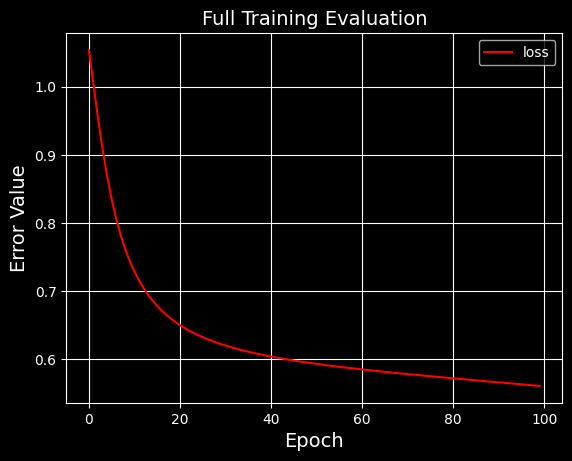

In [36]:
plt.plot(losses_1, label='loss', color='red')
plt.title('Full Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [37]:
model_1 = FullNeuralNetwork(5000,3)
state = torch.load("./torch_models/model_1.pth")
model_1.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [38]:
predictions_1 = model_1.forward(X_test_vec)
predictions_1 = torch.softmax(predictions_1, dim=1)
predictions_1 = torch.argmax(predictions_1, dim=1)
predictions_1

tensor([1, 2, 2,  ..., 1, 1, 1])

In [39]:
y_test.shape

torch.Size([9935])

In [40]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions_1)
accuracy

0.633517866129844

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_1))

              precision    recall  f1-score   support

           0       0.53      0.48      0.51      1550
           1       0.63      0.67      0.65      4451
           2       0.68      0.65      0.67      3934

    accuracy                           0.63      9935
   macro avg       0.61      0.60      0.61      9935
weighted avg       0.63      0.63      0.63      9935



Our final model performance are as follows:

**Macro-Recall** - 0.60 \
**Macro-F1** - 0.61     
**Accuracy** - 0.63

**We will try to improve the performance of `model_1` by resampling the population of our minority `negative` class using Variational AutoEncoder.**

In [42]:
torch.save(y_test, 'tensors/y_test.pt')

In [43]:
torch.save(X_test_vec,'tensors/X_test_vec.pt')

#### **End. Thank you!**